# Convolution Neural Network (CNN)

- This notebooks contains two custom CCN models trained on CIFAR10 Dataset.
-

## Load Dependencies





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab-Notebooks/project-cifar10')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report

from utils.plots import Plot

## Initial Setup

In [4]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from datetime import datetime
now = datetime.now()  # get current datetime object
formatted_date_now = now.strftime("%d-%m-%y")
formatted_time_now = now.strftime("%H:%M:%S")

def get_callbacks():
    # Define early stop on 'val_loss' to stop the process.
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

    # Define reduce LR
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-4, verbose=1)

    return early_stop, reduce_lr

# Define global variables
config_model_results= []    # It will store different configuration results
experiment = 0

## Load Dataset

In [5]:
from keras.datasets import cifar10

def load_dataset():
    try:
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        return X_train, y_train, X_test, y_test
    except Exception as e:
        raise ValueError(f"Dataset could not be loaded: {e}")

# CALL the function
X_train, y_train, X_test, y_test = load_dataset()

# Check the Shapes
print("\n")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)




X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


### Define Classes

In [6]:
# Define the classes
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [7]:
# Print the first class label and name from y_train dataset
print(f"{y_train[0]} : {class_names[y_train[0][0]]}")

# Print the last class label and name from y_train dataset
print(f"{y_train[10000]} : {class_names[y_train[10000][0]]}")

[6] : frog
[1] : automobile


In [8]:
from numpy._core.defchararray import count

# Check the uniques class label in the dataset
# Set return_counts = True
# This return the value count for each class
unique_classes, counts = np.unique(y_train, return_counts=True)

print("Unique Classes:", unique_classes)
print("Classes Names:", class_names)
print("Total Unique Classes:", len(unique_classes))

for i in range(len(unique_classes)):
    print(f"{class_names[i]}: {counts[i]}")


Unique Classes: [0 1 2 3 4 5 6 7 8 9]
Classes Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Total Unique Classes: 10
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


In [9]:
from keras.src.random import randint
for _ in range(5):
    idx = np.random.randint(0, len(y_train))
    label = y_train[idx][0]
    print("Class label:", label)
    print("Class name :", class_names[label])
    print("-----")

Class label: 3
Class name : cat
-----
Class label: 8
Class name : ship
-----
Class label: 5
Class name : dog
-----
Class label: 0
Class name : airplane
-----
Class label: 0
Class name : airplane
-----


### Class Distribution

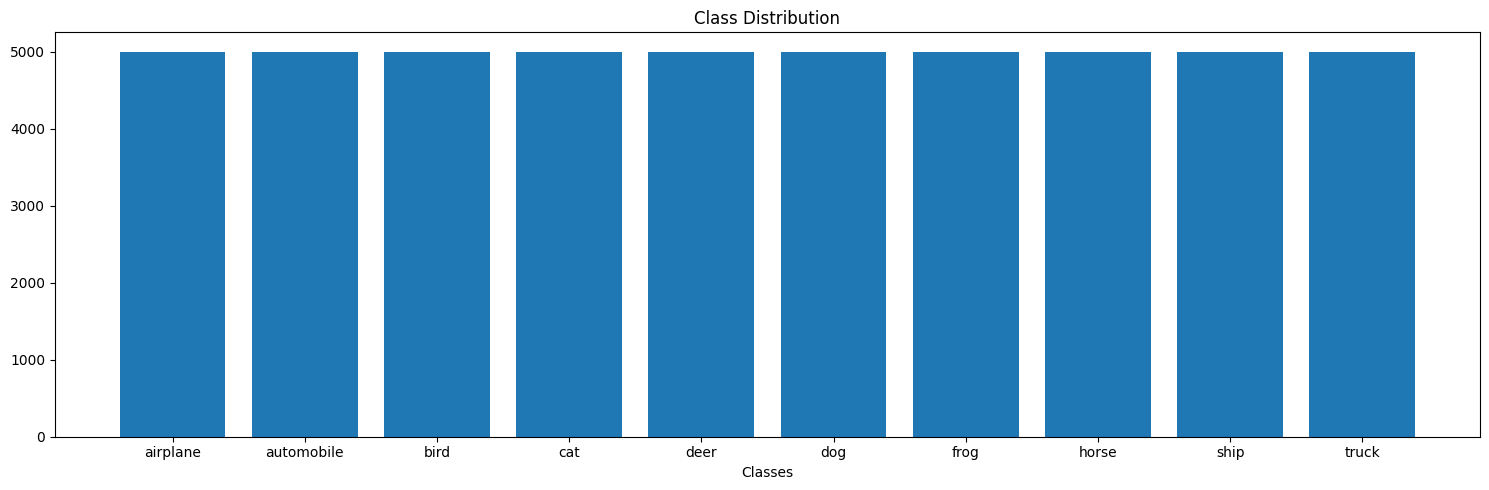

In [10]:
# Check Class Distribution
plt.figure(figsize=(15, 5))
plt.bar(class_names, counts)
plt.title("Class Distribution", fontsize=12)
plt.xlabel("Classes", fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## **Data Visualization**


---



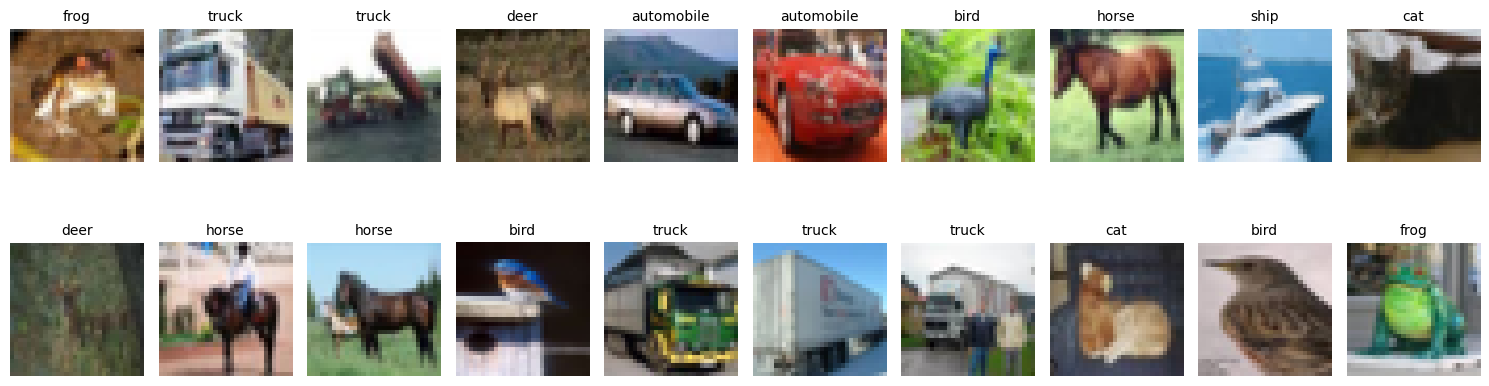

In [11]:
# Visualize Train Data
plt.figure(figsize=(15,5))
print("\n ")
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]], fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

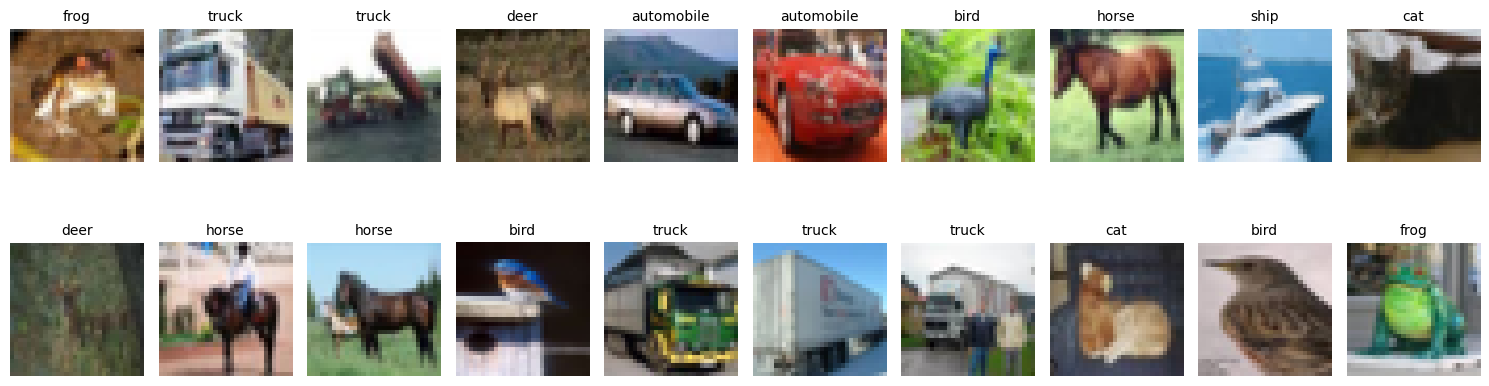

In [12]:
# Visualize Test Data
plt.figure(figsize=(15,5))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i][0]], fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Data Preprocessing

In [13]:
# Apply Normailization
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

## Simple CNN Model

In [14]:
# Build Model Sequential
model = Sequential([

    # Convolution Block 1
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), name= "conv1"),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    # Convolution Block 2
    Conv2D(64, (3,3), activation='relu', name= "conv2"),
    MaxPooling2D((2,2)),

    # Flatten + Dense
    Flatten(),
    Dense(128, activation='relu', name= "dense128"),
    Dense(10, activation='softmax', name='dense_classifier')  # 10 classes
])

# Compile Model
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense128 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_classifier (Dense)        │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def simple_cnn(model_name, filters1, filters2, dense_units, batch_size, epochs, lr=0.001, normalise=1):
    global experiment
    experiment += 1

    preprocess_config = {"N": normalise, "R": 0, "E": '0'}

    # Build Model Sequential
    model = Sequential([

        # Convolution Block 1
        Conv2D(filters1, (3,3), activation='relu', input_shape=(32,32,3)),
        MaxPooling2D((2,2)),
        Dropout(0.25),

        # Convolution Block 2
        Conv2D(filters2, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        # Flatten + Dense
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dense(10, activation='softmax')  # 10 classes
    ])

    # Compile Model
    optimizer = Adam(learning_rate=lr)
    initial_lr = lr
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"\nRunning experiment: {experiment}\n"
          f"Model config: {model_name} | F1={filters1}, F2={filters2}, Dense={dense_units}, Batch={batch_size}, Epochs={epochs}, LR= {lr}")

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=get_callbacks(),
        verbose=0
    )

    # Retreive final LR
    final_lr = float(model.optimizer.learning_rate.numpy())

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    exp_title = (f"EXPT: {experiment} | F1={filters1}, F2={filters2}, Dense={dense_units} | LR={initial_lr}{final_lr:.5f} | BS={batch_size}")

    print("\nTraining Curves")
    plotter= Plot(history=history, title=exp_title)
    plotter.plot_curve()

    print("\nConfusion Matrix")
    plotter.heatmap(y_test, y_pred, class_names)

    print("\nClassification Report")
    print(classification_report(y_test, y_pred, target_names=class_names))
    print("=================================")
    print("\n")

    # Identify best epoch based on validation accuracy
    best_idx = np.argmax(history.history['val_accuracy'])
    best_epoch = best_idx + 1

    config_model_results.append({
        "experiment": experiment,
        "model_name": model_name,
        "preprocess_config": preprocess_config,
        "filters1": filters1,
        "filters2": filters2,
        "dense": dense_units,
        "batch_size": batch_size,
        "initial_lr": round(initial_lr, 5),
        "final_lr": round(final_lr, 6),
        "eph_planned": epochs,
        "eph_trained": len(history.history['loss']),
        "best_epoch": best_epoch,
        "total_params": model.count_params(),
        "best_train_acc": round(history.history['accuracy'][best_idx], 4),
        # "best_train_loss": round(history.history['loss'][best_idx],4),
        "best_val_acc": round(history.history['val_accuracy'][best_idx],4),
        # "best_val_loss": round(history.history['val_loss'][best_idx], 4),
        "overfit_gap_best": round((history.history['accuracy'][best_idx] - history.history['val_accuracy'][best_idx]),4)*100,
        "test_acc": test_acc,
        # "test_loss": test_loss
    })
    return model, history


Running experiment: 1
Model config: base_32_64_d64 | F1=32, F2=64, Dense=64, Batch=32, Epochs=50, LR= 0.001

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 14.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7018 - loss: 0.8936
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training Curves


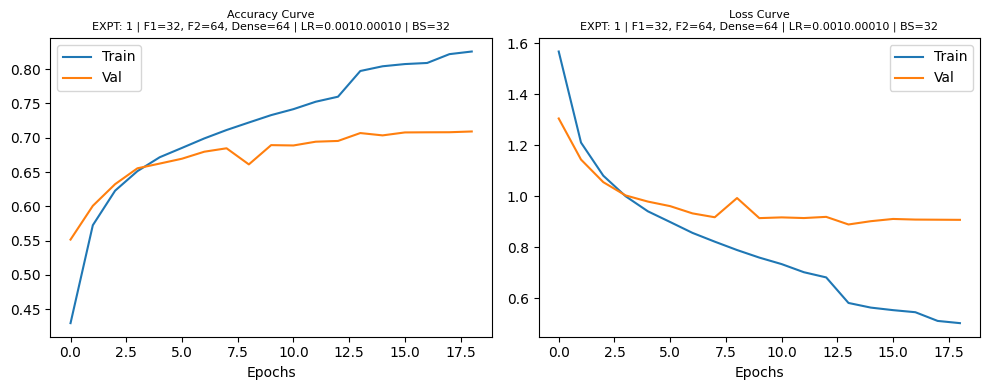


Confusion Matrix


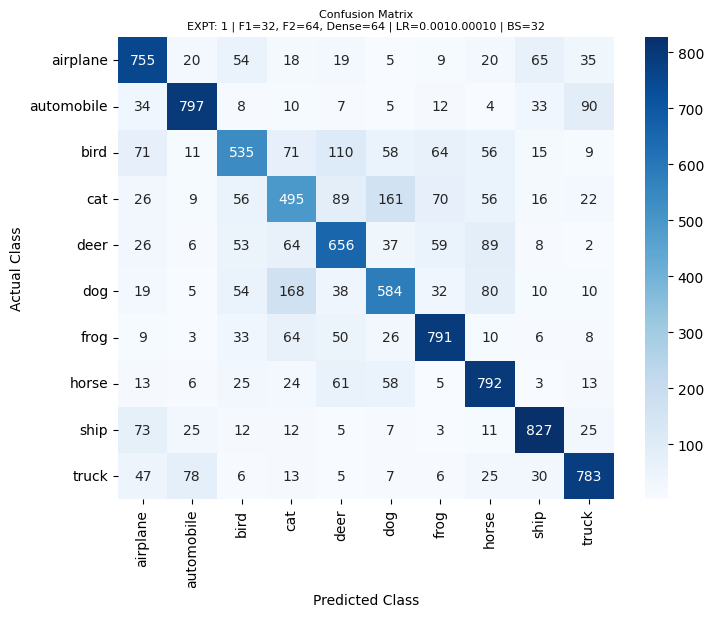


Classification Report
              precision    recall  f1-score   support

    airplane       0.70      0.76      0.73      1000
  automobile       0.83      0.80      0.81      1000
        bird       0.64      0.54      0.58      1000
         cat       0.53      0.49      0.51      1000
        deer       0.63      0.66      0.64      1000
         dog       0.62      0.58      0.60      1000
        frog       0.75      0.79      0.77      1000
       horse       0.69      0.79      0.74      1000
        ship       0.82      0.83      0.82      1000
       truck       0.79      0.78      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000




Running experiment: 2
Model config: base_32_64_d128 | F1=32, F2=64, Dense=128, Batch=32, Epochs=50, LR= 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7045 - loss: 0.8901
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training Curves


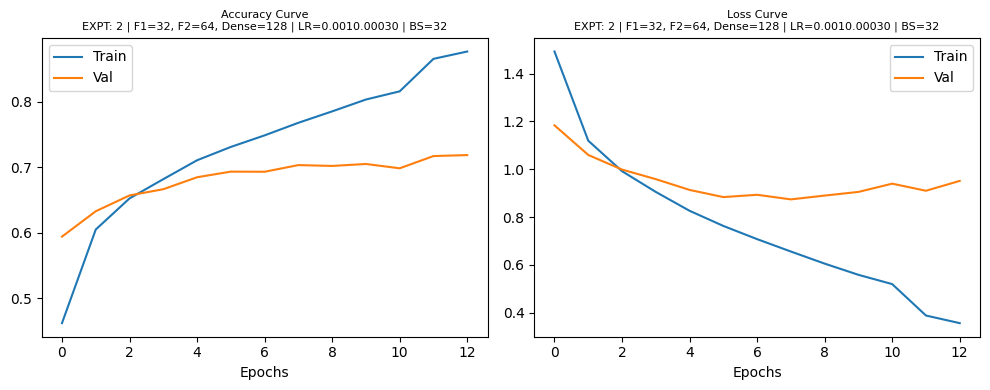


Confusion Matrix


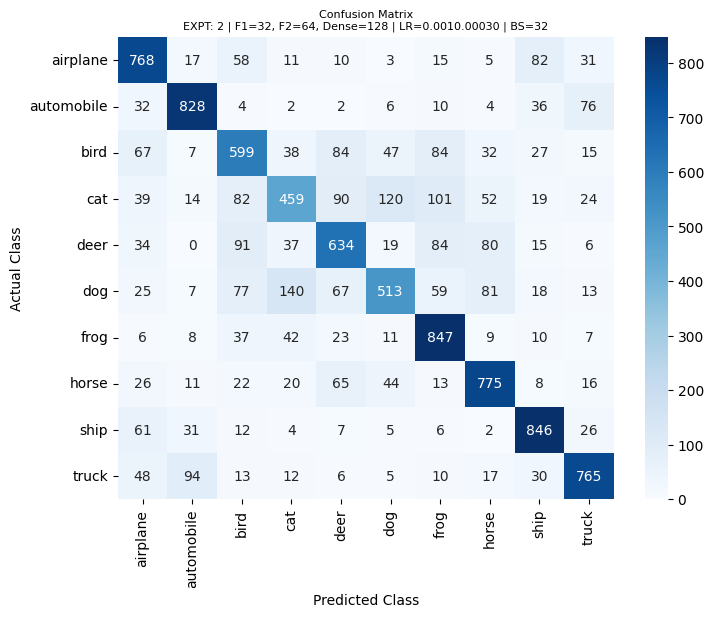


Classification Report
              precision    recall  f1-score   support

    airplane       0.69      0.77      0.73      1000
  automobile       0.81      0.83      0.82      1000
        bird       0.60      0.60      0.60      1000
         cat       0.60      0.46      0.52      1000
        deer       0.64      0.63      0.64      1000
         dog       0.66      0.51      0.58      1000
        frog       0.69      0.85      0.76      1000
       horse       0.73      0.78      0.75      1000
        ship       0.78      0.85      0.81      1000
       truck       0.78      0.77      0.77      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000




Running experiment: 3
Model config: base_32_64_d256 | F1=32, F2=64, Dense=256, Batch=32, Epochs=50, LR= 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6925 - loss: 0.9063
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training Curves


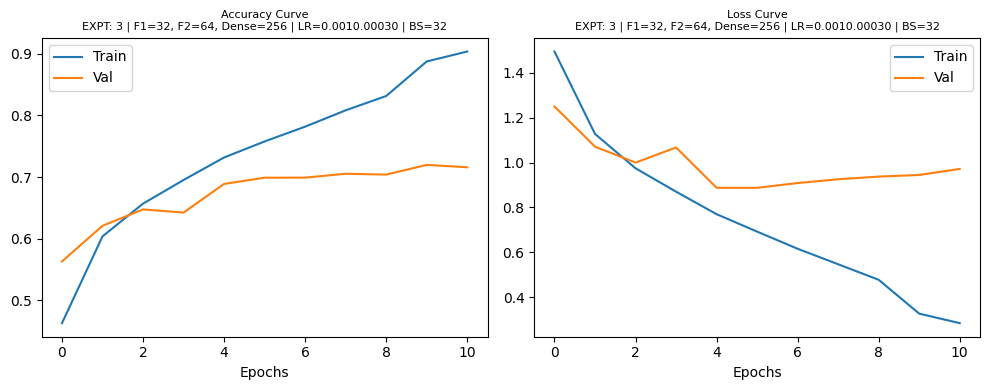


Confusion Matrix


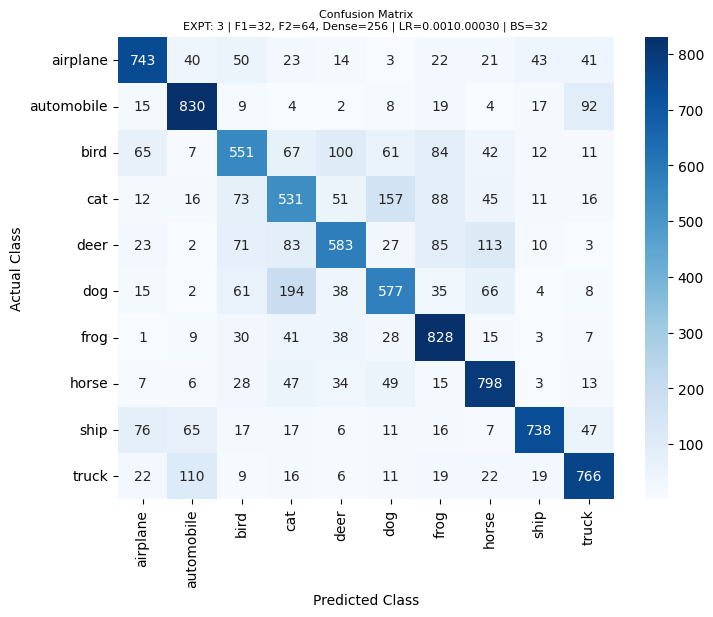


Classification Report
              precision    recall  f1-score   support

    airplane       0.76      0.74      0.75      1000
  automobile       0.76      0.83      0.80      1000
        bird       0.61      0.55      0.58      1000
         cat       0.52      0.53      0.52      1000
        deer       0.67      0.58      0.62      1000
         dog       0.62      0.58      0.60      1000
        frog       0.68      0.83      0.75      1000
       horse       0.70      0.80      0.75      1000
        ship       0.86      0.74      0.79      1000
       truck       0.76      0.77      0.76      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000





(<Sequential name=sequential_3, built=True>,
 <keras.src.callbacks.history.History at 0x7bbc38370bc0>)

In [16]:
# baseline experiments
simple_cnn('base_32_64_d64', 32, 64, 64, 32, 50)
simple_cnn('base_32_64_d128', 32, 64, 128, 32, 50)
simple_cnn('base_32_64_d256', 32, 64, 256, 32, 50)


Running experiment: 4
Model config: mid_32_128_d128 | F1=32, F2=128, Dense=128, Batch=32, Epochs=50, LR= 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7129 - loss: 0.8992
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training Curves


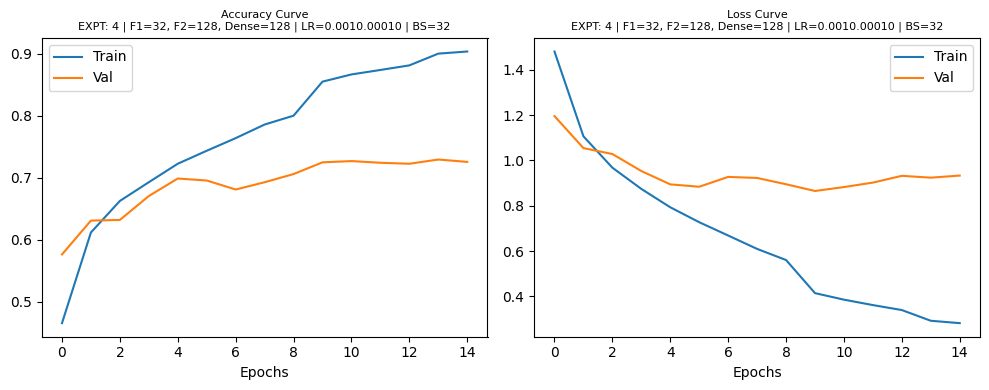


Confusion Matrix


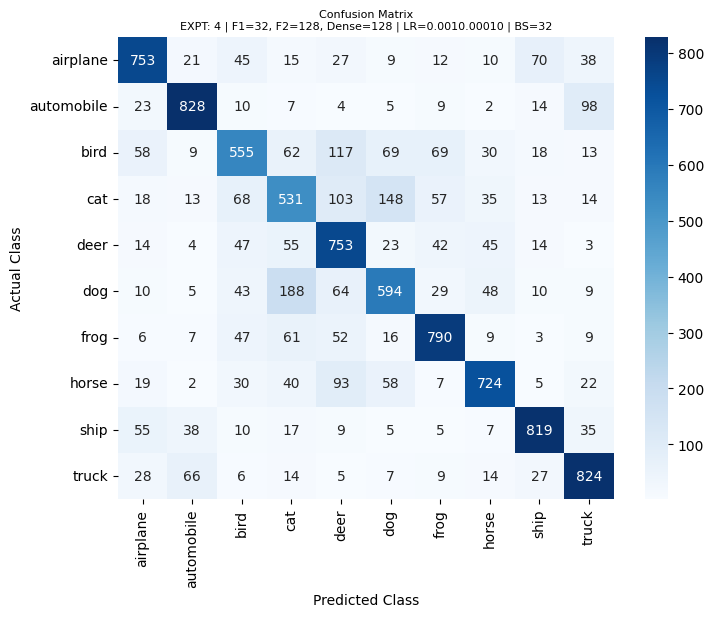


Classification Report
              precision    recall  f1-score   support

    airplane       0.77      0.75      0.76      1000
  automobile       0.83      0.83      0.83      1000
        bird       0.64      0.56      0.60      1000
         cat       0.54      0.53      0.53      1000
        deer       0.61      0.75      0.68      1000
         dog       0.64      0.59      0.61      1000
        frog       0.77      0.79      0.78      1000
       horse       0.78      0.72      0.75      1000
        ship       0.82      0.82      0.82      1000
       truck       0.77      0.82      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000




Running experiment: 5
Model config: mid_32_128_d256 | F1=32, F2=128, Dense=256, Batch=32, Epochs=50, LR= 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7143 - loss: 0.8526
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training Curves


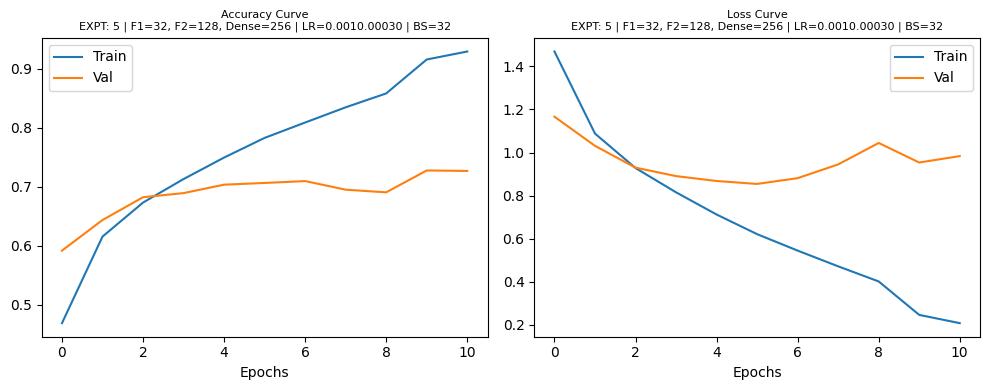


Confusion Matrix


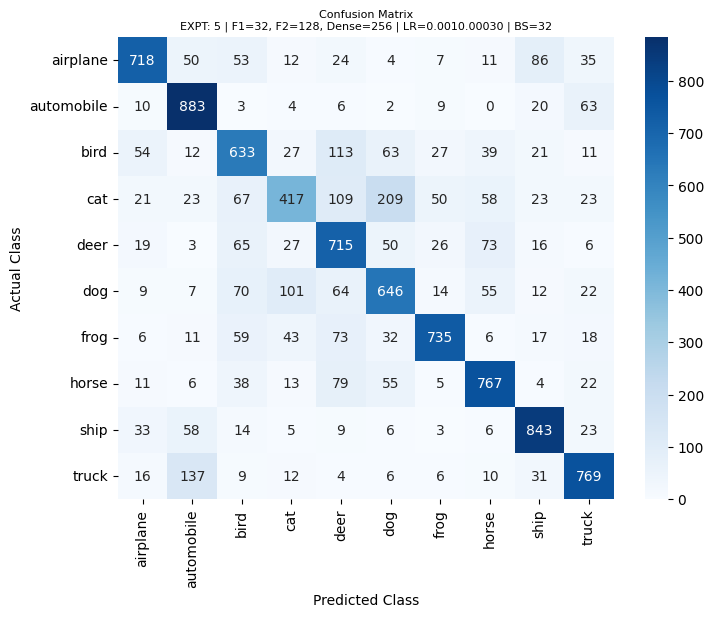


Classification Report
              precision    recall  f1-score   support

    airplane       0.80      0.72      0.76      1000
  automobile       0.74      0.88      0.81      1000
        bird       0.63      0.63      0.63      1000
         cat       0.63      0.42      0.50      1000
        deer       0.60      0.71      0.65      1000
         dog       0.60      0.65      0.62      1000
        frog       0.83      0.73      0.78      1000
       horse       0.75      0.77      0.76      1000
        ship       0.79      0.84      0.81      1000
       truck       0.78      0.77      0.77      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000





(<Sequential name=sequential_5, built=True>,
 <keras.src.callbacks.history.History at 0x7bbc5059a900>)

In [17]:
# medium wider experiments
simple_cnn('mid_32_128_d128', 32, 128, 128, 32, 50)
simple_cnn('mid_32_128_d256', 32, 128, 256, 32, 50)


Running experiment: 6
Model config: wide_64_128_d128 | F1=64, F2=128, Dense=128, Batch=32, Epochs=50, LR= 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6989 - loss: 0.8780
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training Curves


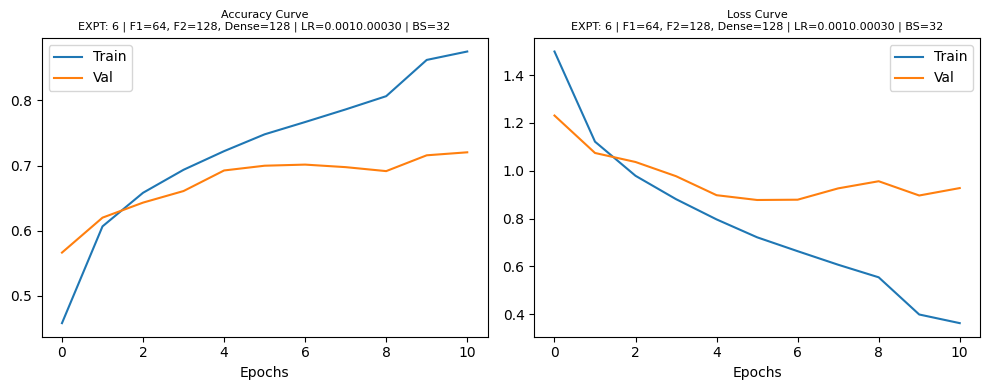


Confusion Matrix


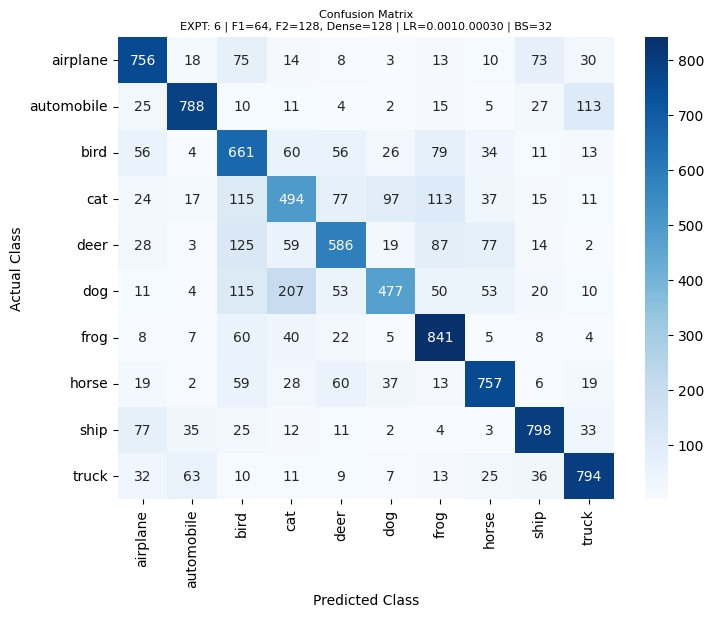


Classification Report
              precision    recall  f1-score   support

    airplane       0.73      0.76      0.74      1000
  automobile       0.84      0.79      0.81      1000
        bird       0.53      0.66      0.59      1000
         cat       0.53      0.49      0.51      1000
        deer       0.66      0.59      0.62      1000
         dog       0.71      0.48      0.57      1000
        frog       0.68      0.84      0.75      1000
       horse       0.75      0.76      0.75      1000
        ship       0.79      0.80      0.79      1000
       truck       0.77      0.79      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.69     10000
weighted avg       0.70      0.70      0.69     10000




Running experiment: 7
Model config: wide_64_128_d256 | F1=64, F2=128, Dense=256, Batch=32, Epochs=50, LR= 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7131 - loss: 0.8413
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training Curves


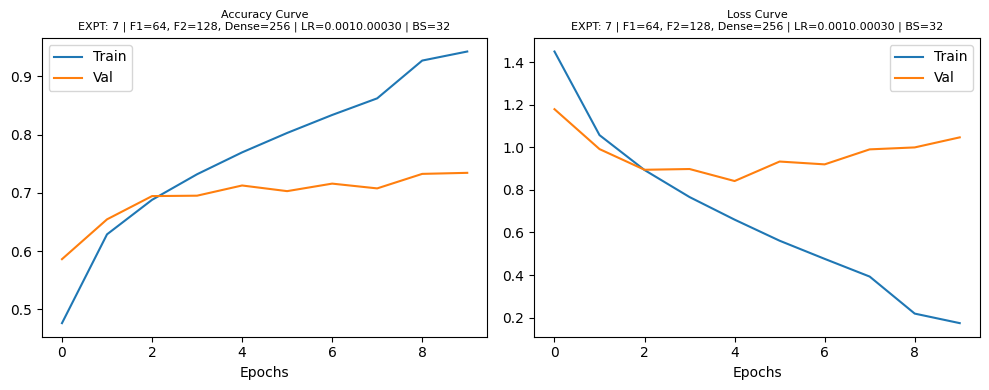


Confusion Matrix


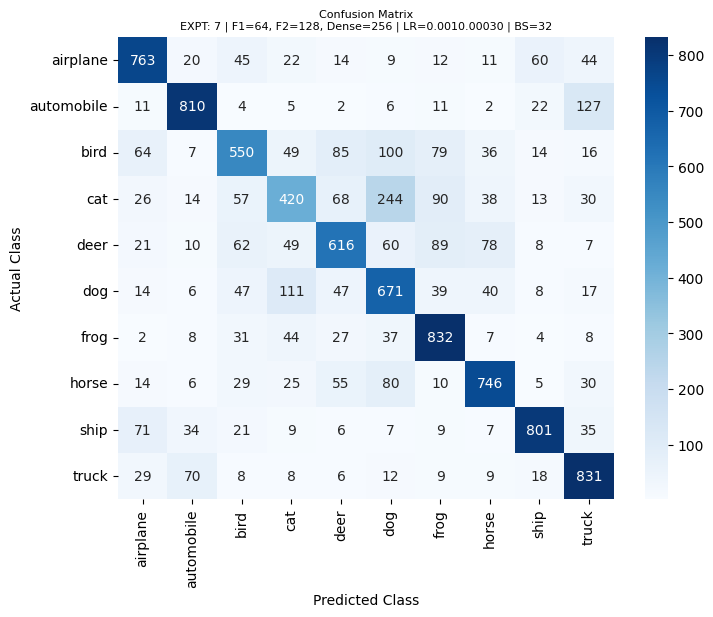


Classification Report
              precision    recall  f1-score   support

    airplane       0.75      0.76      0.76      1000
  automobile       0.82      0.81      0.82      1000
        bird       0.64      0.55      0.59      1000
         cat       0.57      0.42      0.48      1000
        deer       0.67      0.62      0.64      1000
         dog       0.55      0.67      0.60      1000
        frog       0.71      0.83      0.76      1000
       horse       0.77      0.75      0.76      1000
        ship       0.84      0.80      0.82      1000
       truck       0.73      0.83      0.77      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000





(<Sequential name=sequential_7, built=True>,
 <keras.src.callbacks.history.History at 0x7bbc2389bf80>)

In [18]:
# Wider convolutions
simple_cnn('wide_64_128_d128', 64, 128, 128, 32, 50)
simple_cnn('wide_64_128_d256', 64, 128, 256, 32, 50)


Running experiment: 8
Model config: high_128_256_d256 | F1=128, F2=256, Dense=256, Batch=32, Epochs=50, LR= 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 5.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7081 - loss: 0.8924
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training Curves


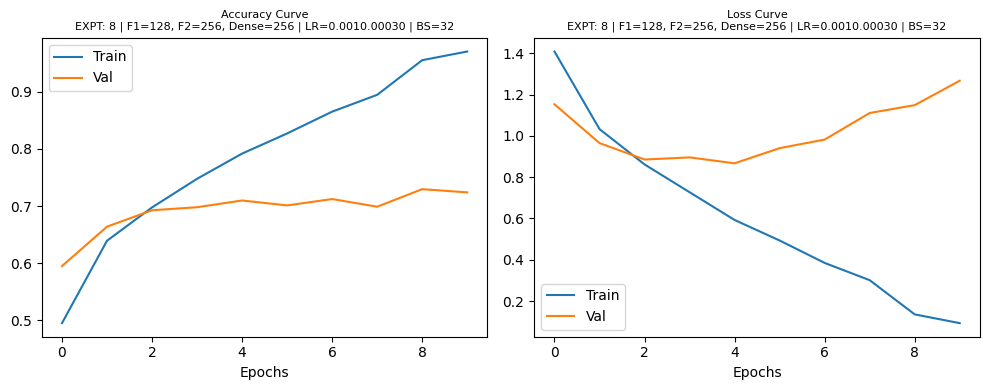


Confusion Matrix


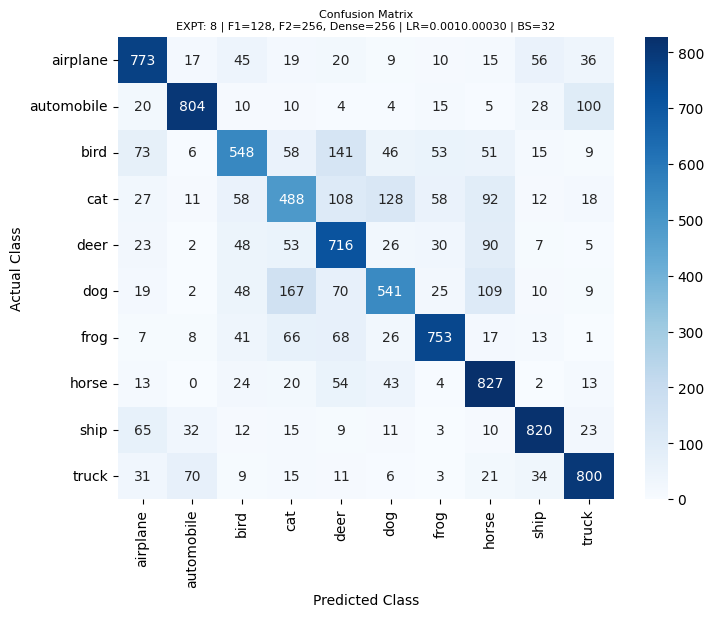


Classification Report
              precision    recall  f1-score   support

    airplane       0.74      0.77      0.75      1000
  automobile       0.84      0.80      0.82      1000
        bird       0.65      0.55      0.59      1000
         cat       0.54      0.49      0.51      1000
        deer       0.60      0.72      0.65      1000
         dog       0.64      0.54      0.59      1000
        frog       0.79      0.75      0.77      1000
       horse       0.67      0.83      0.74      1000
        ship       0.82      0.82      0.82      1000
       truck       0.79      0.80      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000





(<Sequential name=sequential_8, built=True>,
 <keras.src.callbacks.history.History at 0x7bbc5044a600>)

In [19]:
# Much Wider
simple_cnn('high_128_256_d256', 128, 256, 256, 32, 50)


Running experiment: 9
Model config: base_lr0005 | F1=32, F2=64, Dense=128, Batch=32, Epochs=50, LR= 0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 12.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7097 - loss: 0.8682
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training Curves


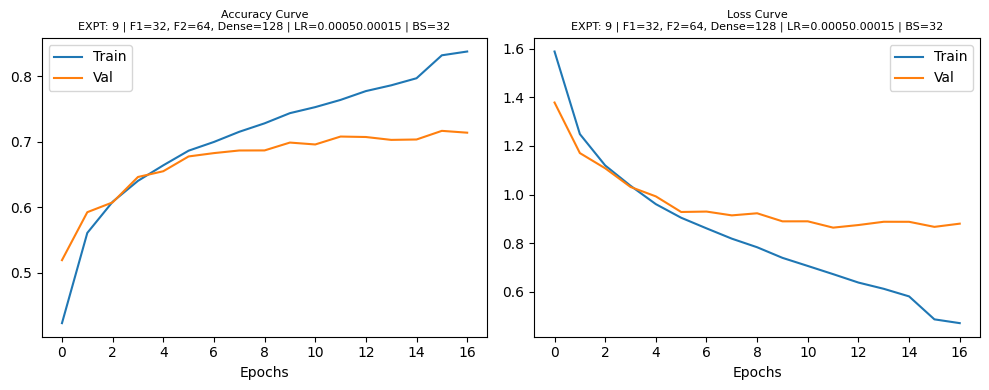


Confusion Matrix


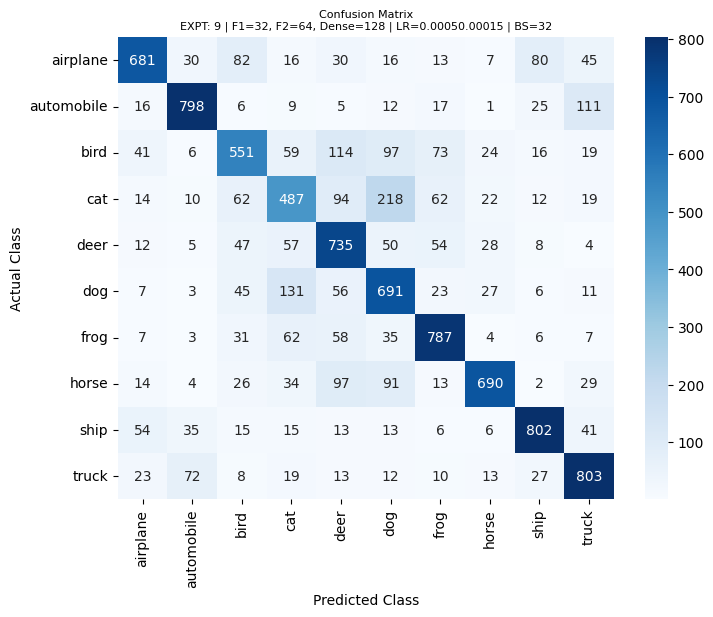


Classification Report
              precision    recall  f1-score   support

    airplane       0.78      0.68      0.73      1000
  automobile       0.83      0.80      0.81      1000
        bird       0.63      0.55      0.59      1000
         cat       0.55      0.49      0.52      1000
        deer       0.60      0.73      0.66      1000
         dog       0.56      0.69      0.62      1000
        frog       0.74      0.79      0.76      1000
       horse       0.84      0.69      0.76      1000
        ship       0.82      0.80      0.81      1000
       truck       0.74      0.80      0.77      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000




Running experiment: 10
Model config: wide_lr0005 | F1=64, F2=128, Dense=256, Batch=32, Epochs=50, LR= 0.0005


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7143 - loss: 0.8586
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training Curves


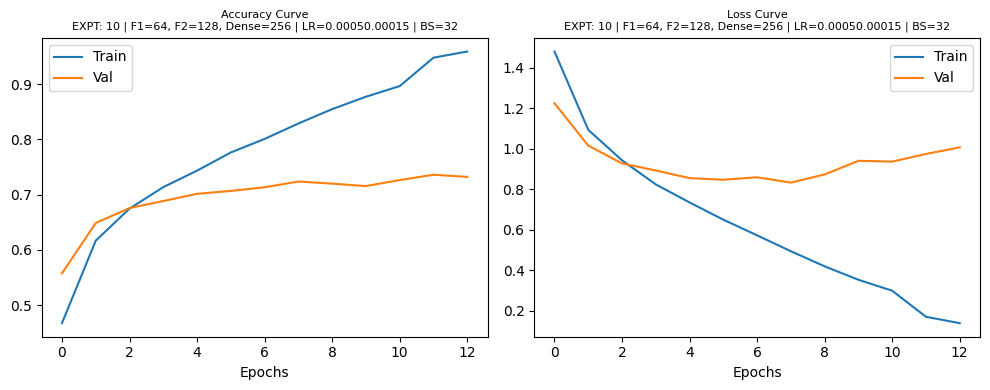


Confusion Matrix


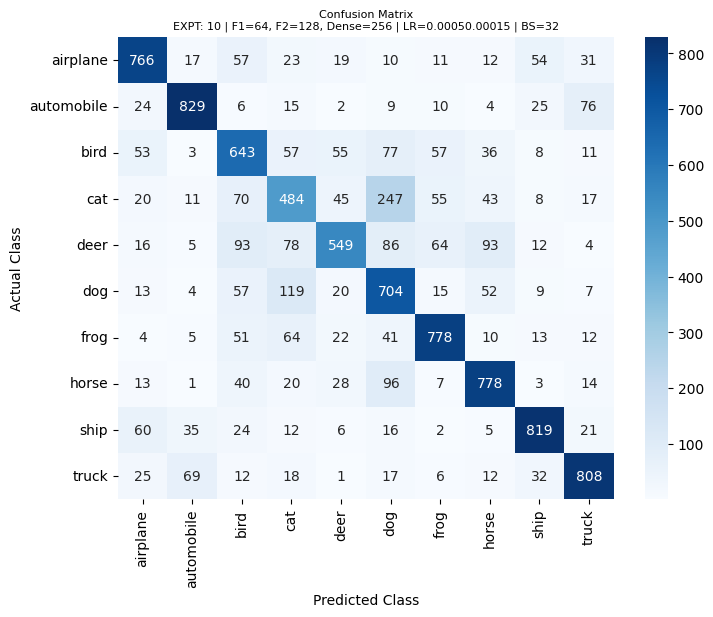


Classification Report
              precision    recall  f1-score   support

    airplane       0.77      0.77      0.77      1000
  automobile       0.85      0.83      0.84      1000
        bird       0.61      0.64      0.63      1000
         cat       0.54      0.48      0.51      1000
        deer       0.73      0.55      0.63      1000
         dog       0.54      0.70      0.61      1000
        frog       0.77      0.78      0.78      1000
       horse       0.74      0.78      0.76      1000
        ship       0.83      0.82      0.83      1000
       truck       0.81      0.81      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000





(<Sequential name=sequential_10, built=True>,
 <keras.src.callbacks.history.History at 0x7bbb8c695910>)

In [20]:
# LR Experiments
simple_cnn('base_lr0005', 32, 64, 128, 32, 50, lr= 0.0005)
simple_cnn('wide_lr0005', 64, 128, 256, 32, 50, lr= 0.0005)


Running experiment: 11
Model config: batch_64 | F1=32, F2=65, Dense=128, Batch=64, Epochs=50, LR= 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 15: early stopping
Restoring model weights from the end of the best epoch: 10.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7059 - loss: 0.8835
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Training Curves


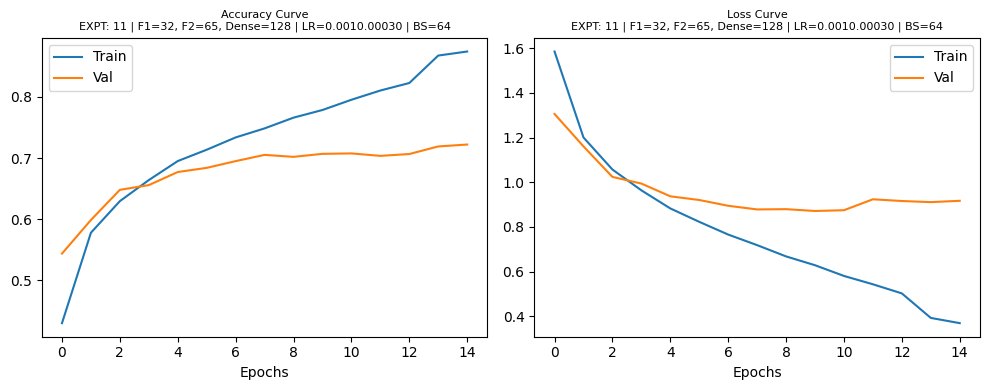


Confusion Matrix


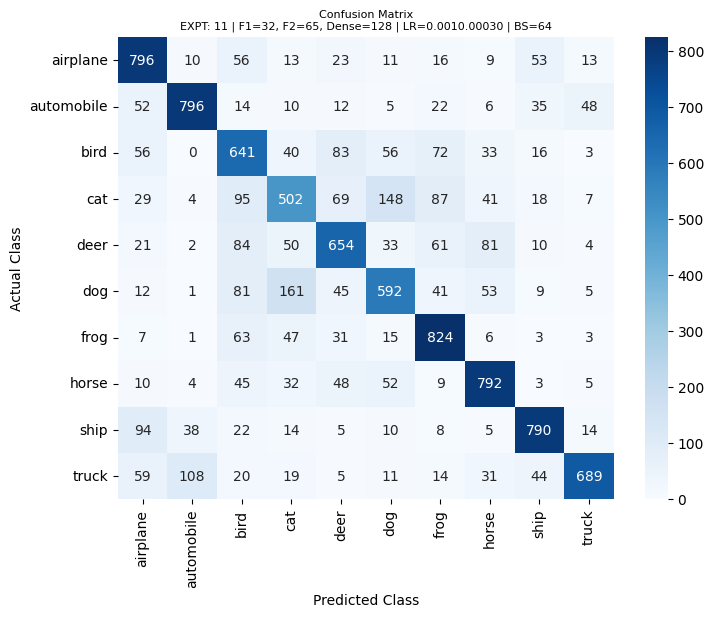


Classification Report
              precision    recall  f1-score   support

    airplane       0.70      0.80      0.75      1000
  automobile       0.83      0.80      0.81      1000
        bird       0.57      0.64      0.60      1000
         cat       0.57      0.50      0.53      1000
        deer       0.67      0.65      0.66      1000
         dog       0.63      0.59      0.61      1000
        frog       0.71      0.82      0.77      1000
       horse       0.75      0.79      0.77      1000
        ship       0.81      0.79      0.80      1000
       truck       0.87      0.69      0.77      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000




Running experiment: 12
Model config: batch_128 | F1=64, F2=128, Dense=256, Batch=128, Epochs=50, LR= 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 8.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7118 - loss: 0.8487
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Training Curves


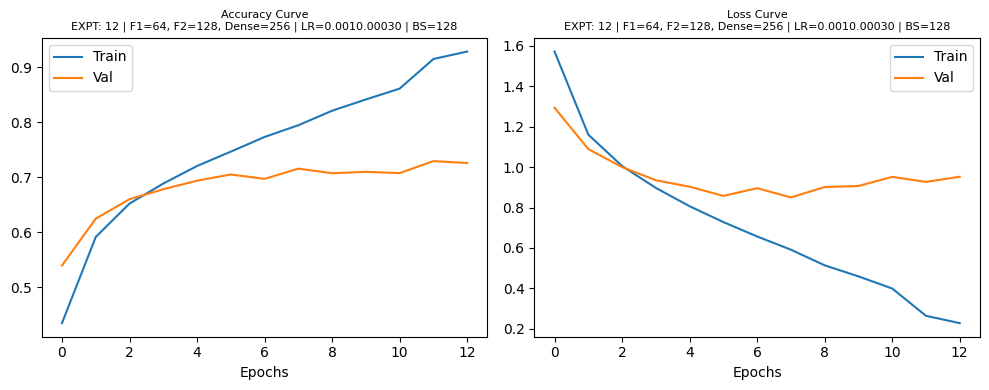


Confusion Matrix


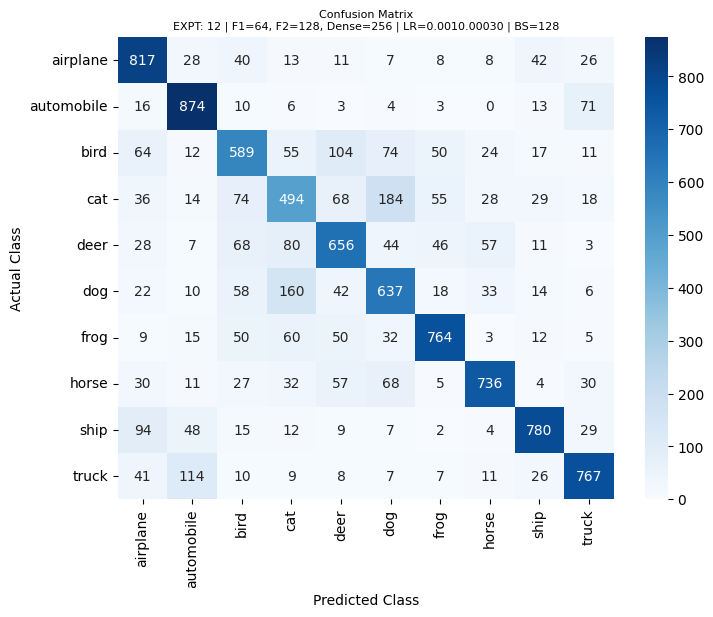


Classification Report
              precision    recall  f1-score   support

    airplane       0.71      0.82      0.76      1000
  automobile       0.77      0.87      0.82      1000
        bird       0.63      0.59      0.61      1000
         cat       0.54      0.49      0.51      1000
        deer       0.65      0.66      0.65      1000
         dog       0.60      0.64      0.62      1000
        frog       0.80      0.76      0.78      1000
       horse       0.81      0.74      0.77      1000
        ship       0.82      0.78      0.80      1000
       truck       0.79      0.77      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000





(<Sequential name=sequential_12, built=True>,
 <keras.src.callbacks.history.History at 0x7bbb8c6dabd0>)

In [21]:
# Batch Size Experiments
simple_cnn('batch_64', 32, 65, 128, 64, 50)
simple_cnn('batch_128', 64, 128, 256, 128, 50)

In [22]:
results_df = pd.DataFrame(config_model_results)
results_df

,experiment,model_name,preprocess_config,filters1,filters2,dense,batch_size,initial_lr,final_lr,eph_planned,eph_trained,best_epoch,total_params,best_train_acc,best_val_acc,overfit_gap_best,test_acc
0,1,base_32_64_d64,"{'N': 1, 'R': 0, 'E': '0'}",32,64,64,32,0.0010,0.00010,50,19,19,167562,0.8257,0.7091,11.66,0.7015
1,2,base_32_64_d128,"{'N': 1, 'R': 0, 'E': '0'}",32,64,128,32,0.0010,0.00030,50,13,13,315722,0.8771,0.7187,15.84,0.7034
2,3,base_32_64_d256,"{'N': 1, 'R': 0, 'E': '0'}",32,64,256,32,0.0010,0.00030,50,11,10,612042,0.8872,0.7196,16.76,0.6945
3,4,mid_32_128_d128,"{'N': 1, 'R': 0, 'E': '0'}",32,128,128,32,0.0010,0.00010,50,15,14,629130,0.9000,0.7294,17.07,0.7171
4,5,mid_32_128_d256,"{'N': 1, 'R': 0, 'E': '0'}",32,128,256,32,0.0010,0.00030,50,11,10,1220362,0.9161,0.7278,18.83,0.7126
5,6,wide_64_128_d128,"{'N': 1, 'R': 0, 'E': '0'}",64,128,128,32,0.0010,0.00030,50,11,11,666890,0.8752,0.7203,15.49,0.6952
6,7,wide_64_128_d256,"{'N': 1, 'R': 0, 'E': '0'}",64,128,256,32,0.0010,0.00030,50,10,10,1258122,0.9426,0.7344,20.82,0.7040
7,8,high_128_256_d256,"{'N': 1, 'R': 0, 'E': '0'}",128,256,256,32,0.0010,0.00030,50,10,9,2660874,0.9554,0.7297,22.57,0.7070
8,9,base_lr0005,"{'N': 1, 'R': 0, 'E': '0'}",32,64,128,32,0.0005,0.00015,50,17,16,315722,0.8324,0.7169,11.55,0.7025
9,10,wide_lr0005,"{'N': 1, 'R': 0, 'E': '0'}",64,128,256,32,0.0005,0.00015,50,13,12,1258122,0.9478,0.7360,21.18,0.7158


In [23]:
from google.colab import files
results_df.to_csv("cnn_experiment_results.csv", index=False)
files.download("simple_cnn_experiment_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>